In [1]:
# downloading keras tuner
!pip install -q keras-tuner

In [2]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# general settings
from numpy.random import seed
seed(42)
from keras.utils import set_random_seed
set_random_seed(42)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading data
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# getting dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
# drop duplicates if any
df = df.drop_duplicates()

In [7]:
# encoding target feature
df['species'] = df['species'].map({'setosa':0, 'versicolor':1, 'virginica':2})
df['species'].value_counts()

0    50
1    50
2    49
Name: species, dtype: int64

In [8]:
# creating X & y
X = df.drop(columns=['species'], axis=1)
y = to_categorical(y=df['species'], num_classes=3)

In [9]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [10]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# defining search space
def model_builder(hp):

  model = Sequential()

  hp_layer_1 = hp.Int(name='units_1', min_value=2, max_value=10)
  hp_layer_2 = hp.Int(name='units_2', min_value=2, max_value=10)
  hp_activation = hp.Choice(name='activation', values=['relu', 'tanh', 'selu'])
  hp_lr = hp.Float(name='LR', min_value=0.01, max_value=0.05, step=0.01)

  model.add(Dense(units=hp_layer_1, activation=hp_activation, input_dim=4))
  if hp.Boolean(name='dropout'):
    model.add(Dropout(rate=0.2))
  model.add(Dense(units=hp_layer_2, activation=hp_activation))
  model.add(Dense(units=3, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [12]:
# creating tuner object
tuner = kt.GridSearch(hypermodel=model_builder, max_trials=20, objective='val_accuracy',
                      directory='mydir', project_name='myproject', seed=420)

In [13]:
# finding best hps
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, verbose=0)

In [14]:
# checking best hps
tuner.results_summary(num_trials=1)

Results summary
Results in mydir/myproject
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
units_1: 2
units_2: 2
activation: selu
LR: 0.01
Score: 1.0


In [15]:
# getting model with best hps
model = tuner.get_best_models()[0]

In [16]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 3)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [17]:
# training model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, initial_epoch=21, batch_size=20, verbose=1,
          callbacks=EarlyStopping(patience=2))

Epoch 22/40
6/6 [==============================] - 1s 73ms/step - loss: 0.2922 - accuracy: 0.8908 - val_loss: 0.2557 - val_accuracy: 1.0000
Epoch 23/40
6/6 [==============================] - 0s 17ms/step - loss: 0.2789 - accuracy: 0.8908 - val_loss: 0.2415 - val_accuracy: 1.0000
Epoch 24/40
6/6 [==============================] - 0s 13ms/step - loss: 0.2627 - accuracy: 0.8992 - val_loss: 0.2224 - val_accuracy: 1.0000
Epoch 25/40
6/6 [==============================] - 0s 11ms/step - loss: 0.2496 - accuracy: 0.8992 - val_loss: 0.2057 - val_accuracy: 1.0000
Epoch 26/40
6/6 [==============================] - 0s 8ms/step - loss: 0.2363 - accuracy: 0.9076 - val_loss: 0.1918 - val_accuracy: 1.0000
Epoch 27/40
6/6 [==============================] - 0s 9ms/step - loss: 0.2227 - accuracy: 0.9160 - val_loss: 0.1774 - val_accuracy: 1.0000
Epoch 28/40
6/6 [==============================] - 0s 10ms/step - loss: 0.2088 - accuracy: 0.9328 - val_loss: 0.1678 - val_accuracy: 1.0000
Epoch 29/40
6/6 [=====

In [18]:
# model evaluation
_, train_accu = model.evaluate(X_train, y_train, batch_size=20, verbose=0)
print('Training Accuracy:', round(train_accu * 100, 2))
_, test_accu = model.evaluate(X_test, y_test, batch_size=20, verbose=0)
print('Testing Accuracy:', round(test_accu * 100, 2))

Training Accuracy: 94.96
Testing Accuracy: 96.67


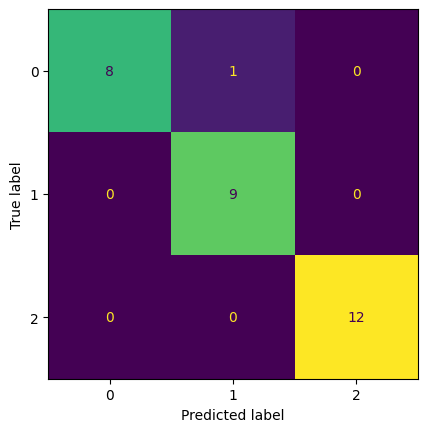

In [19]:
# plotting confusion matrix
cm = confusion_matrix(
    y_true = np.argmax(y_test, axis=1),
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1))
disp = ConfusionMatrixDisplay(cm)
disp.plot(colorbar=False);

In [20]:
# getting clf report
print(classification_report(
    y_true = np.argmax(y_test, axis=1),
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00        12

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

